In [1]:
import tensorflow as tf
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import datasets, layers, models, applications, Sequential, Model, backend
from tensorflow.keras import optimizers, initializers, regularizers, metrics, utils

# En-De

In [2]:
HEIGHT = 512
WIDTH = 512
class_num = 1
input_shape = (HEIGHT,WIDTH,3)
input_tensor = layers.Input((HEIGHT, WIDTH, 3))

In [3]:
def Unet(x, train_bn=True):
    #Encoder
    f1_1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='SAME')(x)
    f1_1 = layers.BatchNormalization()(f1_1, training=train_bn)
    f1_1 = layers.LeakyReLU()(f1_1) #256x256x64

    f1_2 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='SAME')(x)
    f1_2 = layers.BatchNormalization()(f1_2, training=train_bn)
    f1_2 = layers.LeakyReLU()(f1_2) #256x256x64

    f1 = layers.concatenate([f1_1, f1_2]) #256x256x128
    f1 = layers.MaxPool2D(pool_size=(2, 2), padding='SAME')(f1)


    f2_1 = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='SAME')(f1)
    f2_1 = layers.BatchNormalization()(f2_1, training=train_bn)
    f2_1 = layers.LeakyReLU()(f2_1) #128x128x128

    f2_2 = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='SAME')(f1)
    f2_2 = layers.BatchNormalization()(f2_2, training=train_bn)
    f2_2 = layers.LeakyReLU()(f2_2) #128x128x128

    f2 = layers.concatenate([f2_1, f2_2]) #128x128x256
    f2 = layers.MaxPool2D(pool_size=(2, 2), padding='SAME')(f2)


    f3_1 = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='SAME')(f2)
    f3_1 = layers.BatchNormalization()(f3_1, training=train_bn)
    f3_1 = layers.LeakyReLU()(f3_1) #64x64x128

    f3_2 = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='SAME')(f2)
    f3_2 = layers.BatchNormalization()(f3_2, training=train_bn)
    f3_2 = layers.LeakyReLU()(f3_2) #64x64x128

    f3 = layers.concatenate([f3_1, f3_2]) #64x64x256
    f3 = layers.MaxPool2D(pool_size=(2, 2), padding='SAME')(f3)


    f4_1 = layers.Conv2D(256, (5, 5), strides=(1, 1), padding='SAME')(f3)
    f4_1 = layers.BatchNormalization()(f4_1, training=train_bn)
    f4_1 = layers.LeakyReLU()(f4_1) #32x32x256

    f4_2 = layers.Conv2D(256, (5, 5), strides=(1, 1), padding='SAME')(f3)
    f4_2 = layers.BatchNormalization()(f4_2, training=train_bn)
    f4_2 = layers.LeakyReLU()(f4_2) #32x32x256

    f4 = layers.concatenate([f4_1, f4_2]) #32x32x512


    x = layers.Flatten()(f4)
    encode = layers.Dense(256)(x)
    d1 = layers.Dense(32*32*256)(encode)
    d1 = layers.Reshape((32,32,256))(d1)
    d1 = layers.Conv2DTranspose(128, (5, 5), strides=(2,2), padding='SAME')(d1)
    d1 = layers.BatchNormalization()(d1, training=train_bn)
    d1 = layers.LeakyReLU()(d1) #64x64x128

    #Decoder
    d1_uni = layers.concatenate([d1, f3_2]) #64x64x256
    d1_uni = layers.Conv2DTranspose(256, (5, 5), strides=(1,1), padding='SAME')(d1_uni)
    d1_uni = layers.BatchNormalization()(d1_uni, training=train_bn)
    d1_uni = layers.LeakyReLU()(d1_uni) #64x64x256


    d2 = layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='SAME')(d1_uni)
    d2 = layers.BatchNormalization()(d2, training=train_bn)
    d2 = layers.LeakyReLU()(d2) #128x128x128

    d2_uni = layers.concatenate([d2, f2_2]) #128x128x256
    d2_uni = layers.Conv2D(256, (5, 5), strides=(1,1), padding='SAME')(d2_uni)
    d2_uni = layers.BatchNormalization()(d2_uni, training=train_bn)
    d2_uni = layers.LeakyReLU()(d2_uni) #128x128x256


    d3 = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='SAME')(d2_uni)
    d3 = layers.BatchNormalization()(d3, training=train_bn)
    d3 = layers.LeakyReLU()(d3) #256x256x64

    d3_uni = layers.concatenate([d3, f1_2]) #256x256x128
    d3_uni = layers.Conv2D(128, (5,5), strides=(1,1), padding='SAME')(d3_uni)
    d3_uni = layers.BatchNormalization()(d3_uni, training=train_bn)
    d3_uni = layers.LeakyReLU()(d3_uni) #256x256x128

    decoded = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='SAME')(d3_uni)
    decoded = layers.Activation('sigmoid')(decoded) #512x512x1
    
    return decoded

In [4]:
output = Unet(input_tensor)

make model

In [5]:
Pix2Pose = Model(input_tensor, output)
Pix2Pose = utils.multi_gpu_model(Pix2Pose, gpus=2)

Instructions for updating:
Use `tf.distribute.MirroredStrategy` instead.


In [6]:
Pix2Pose.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 512, 512, 1)  213081153   lambda[0][0]                     
                                                                 lambda_1[0][0]             

example image

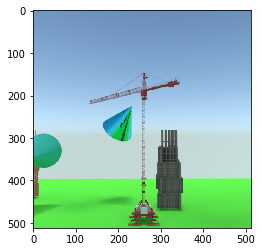

In [7]:
img = plt.imread('./camera20034.png')
plt.imshow(img)

In [8]:
img = tf.reshape(img, (1, 512, 512, 3))
img = tf.cast(img, dtype=tf.float32)

In [9]:
example =Pix2Pose(img)
example.shape

TensorShape([1, 512, 512, 1])

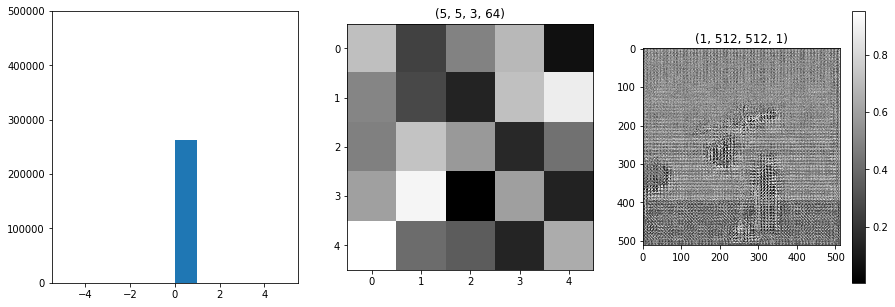

In [10]:
weight = Pix2Pose.get_weights()[0]

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(example.numpy().ravel(), range=[-5,5])
plt.ylim(0, 500000)
plt.subplot(132)
plt.title(weight.shape)
plt.imshow(weight[:,:,0,0], 'gray')
plt.subplot(133)
plt.title(example.shape)
plt.imshow(example[0, :, :, 0], 'gray')
plt.colorbar()
plt.show()

# Load image dataset

In [11]:
train_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/train/*.png')
test_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/test/*.png')
val_paths = glob('C:/Users/IVCL/Desktop/dock5_DR/dataset/val/*.png')

In [12]:
def get_label(path):
    label_name = path[-15:-4]
    label_path = 'C:/Users/IVCL/Desktop/dock5_DR/classify_semantic/%s.png'%label_name
    label = plt.imread(label_path)
    label = label[...,tf.newaxis]
    label = tf.cast(label, dtype=tf.float32)
    
    return label

In [13]:
def read_image(path):
    #read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [HEIGHT, WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = (image / 127.5) - 1
    
    return image

In [14]:
def make_batch(batch_paths):
    batch_images = []
    batch_labels = []
        
    for path in batch_paths:
        image = read_image(path)
        batch_images.append(image)
        
        label = get_label(path)
        batch_labels.append(label)
    
    return tf.convert_to_tensor(batch_images), tf.convert_to_tensor(batch_labels)

In [15]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    test_input = test_input[tf.newaxis, ...]
    prediction = model(test_input, training=False)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[:,:,0], tf.where(prediction[0,:,:,0]>=0.5,1.0,0)]
    
    title = ['Input Image', 'Ground Truth', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

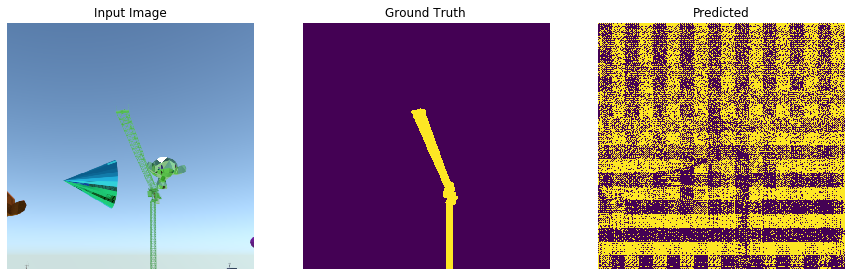

In [16]:
image = read_image(train_paths[0])
label = get_label(train_paths[0])
generate_images(Pix2Pose, image, label)

# Define Loss and Optimizer

In [17]:
# Define loss and optimizer
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

# Metrics

In [18]:
def precision(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_positive = tf.reduce_sum(pred)
    
    precision = true_positive / (true_positive_false_positive + tf.keras.backend.epsilon())
                                 
    return precision

                                 
def recall(truth, pred):
    pred = tf.where(pred >= 0.5, 1.0, 0)
    
    true_positive = tf.reduce_sum(pred * truth)
    true_positive_false_negative = tf.reduce_sum(truth)
    
    recall = true_positive / (true_positive_false_negative + tf.keras.backend.epsilon())
                                 
    return recall

# Checkpoint

In [19]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, Pix2Pose=Pix2Pose)

# Train

In [20]:
#Hyperparameter
BATCH_SIZE = 2
EPOCHS = 20
train_steps_per_epoch = len(train_paths) // BATCH_SIZE
val_steps_per_epoch = len(val_paths)

In [21]:
@tf.function
#def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
def train_step(model, images, labels, loss_object, optimizer, train_loss):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
       
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    #train_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

# Implement algorithm test
@tf.function
#def val_step(model, images, labels, loss_object, val_loss, val_accuracy):
def val_step(model, images, labels, loss_object, val_loss):
    predictions = model(images, training=False)
    
    v_loss = loss_object(labels, predictions)
    val_loss(v_loss)
    #val_accuracy(labels, predictions)
    pre = precision(labels, predictions)
    rec = recall(labels, predictions)
    
    return pre, rec

In [ ]:
loss_list = []
val_loss_list = []

for epoch in range(EPOCHS):
    random.shuffle(train_paths)
    
    train_loss_sum = 0
    val_loss_sum = 0
        
    for step in range(train_steps_per_epoch):
        images, labels = make_batch(train_paths[step * BATCH_SIZE : (step + 1) * BATCH_SIZE])
        
        train_precision, train_recall = train_step(Pix2Pose, images, labels, loss_object, optimizer, train_loss)
        
        #template = 'Step {}, Loss: {}, Accuracy: {}'
        template = 'Epoch {}, Step {}, Loss: {}, Precision: {}, Recall: {}'
        print(template.format(epoch + 1, step + 1,
                              train_loss.result(),
                              train_precision * 100,
                              train_recall * 100))

        train_loss_sum = train_loss_sum + train_loss.result()
        
        train_loss.reset_states()
        val_loss.reset_states()
       
    for step in range(val_steps_per_epoch):
        val_images, val_labels = make_batch(val_paths[step * 1 : (step + 1) * 1])
        
        val_precision, val_recall = val_step(Pix2Pose, val_images, val_labels, loss_object, val_loss)
        
        val_loss_sum = val_loss_sum + val_loss.result()    
    
    loss_list.append(train_loss_sum / len(train_paths))
    val_loss_list.append(val_loss_sum / len(val_paths))
    
    #template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    template = 'Epoch {}, Val_Loss: {}, Val_Precision: {}, Val_Recall: {}'
    print(template.format(epoch + 1,
                          val_loss_sum / len(val_paths),
                          val_precision * 100,
                          val_recall * 100))
    train_loss.reset_states()
    val_loss.reset_states()
  
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

# Loss Curve

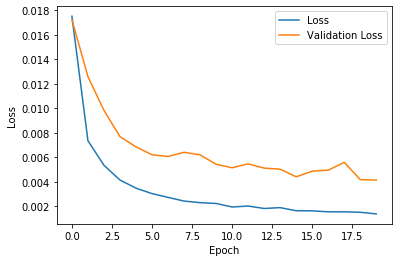

In [23]:
plt.plot(loss_list, label='Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Restore Checkpoint

In [23]:
checkpoint.restore('C:/Users/IVCL/Desktop/Pix2Pose/checkpoints_pooling_dock5_DR/ckpt-4')

# Test

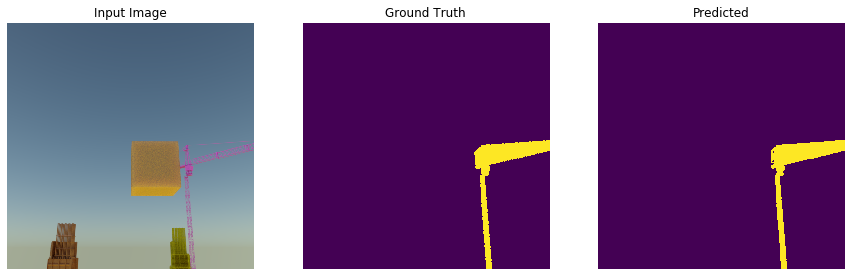

In [24]:
num = 200
image = read_image(test_paths[num])
label = get_label(test_paths[num])
generate_images(Pix2Pose, image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


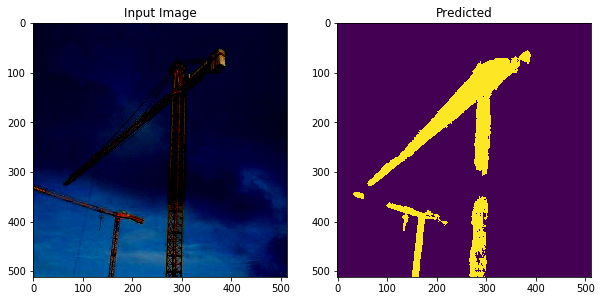

In [27]:
image = read_image('C:/Users/IVCL/Desktop/TC_Real_512/0501.jpg') #411, 272, 501
image = image[tf.newaxis, ...]
prediction = Pix2Pose(image, training=False)

plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image[0])
plt.title('Input Image')

plt.subplot(1,2,2)
plt.imshow(tf.where(prediction[0,:,:,0]>= 0.5, 1.0, 0))
plt.title('Predicted')

plt.show()